In [393]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [394]:
cwd = os.getcwd()
# Read the data
used_dataset_dir = os.path.join(cwd, 'Used_Dataset/cleaned_data')
# Read the data
train_data = pd.read_csv(os.path.join(used_dataset_dir, 'cleaned_data_2020_2022.csv'))
display(train_data.head())
display(train_data.tail())
display(train_data.isnull().sum())
display(train_data.shape)



,Date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,rad(m)
0,2020-01-01,25.2,32.0,27.0,82.0,16.5,6.5,7.0,300.0,3.000000,-0.101338
1,2020-01-02,25.6,31.0,27.9,78.0,5.2,3.5,8.0,270.0,4.000000,-0.080959
2,2020-01-03,25.3,31.5,27.6,82.0,1.5,5.9,10.0,280.0,6.000000,-0.038172
3,2020-01-04,26.5,30.5,27.9,77.0,1.7,4.6,12.0,260.0,8.000000,-0.005176
4,2020-01-05,25.6,31.3,28.6,81.0,8.1,8.0,5.0,6.0,3.133748,-0.007169


,Date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,rad(m)
726,2022-12-27,25.5,29.5,27.5,83.0,6.0,1.2,9.0,270.0,6.0,-0.024320
727,2022-12-28,24.5,29.1,26.9,84.0,2.3,0.0,9.0,270.0,5.0,-0.030015
728,2022-12-29,24.0,30.1,27.0,84.0,35.6,3.2,8.0,260.0,4.0,0.005127
729,2022-12-30,25.9,30.0,27.6,83.0,1.0,4.9,7.0,310.0,3.0,-0.009264
730,2022-12-31,24.9,32.2,27.7,83.0,0.0,0.6,7.0,280.0,3.0,-0.401817


Date      0
Tn        0
Tx        0
Tavg      0
RH_avg    0
RR        0
ss        0
ff_x      0
ddd_x     0
ff_avg    0
rad(m)    0
dtype: int64

(731, 11)

In [395]:
def advanced_condition_classifier(row):
    # Extract critical features
    tn = row['Tn']            # Minimum Temperature
    tx = row['Tx']            # Maximum Temperature
    tavg = row['Tavg']        # Average Temperature
    rh = row['RH_avg']        # Average Relative Humidity
    wind_speed = row['ff_avg'] # Average Wind Speed
    tidal_height = row['rad(m)']  # Normalized tidal height (meters)

    # High Risk (Unsafe) Conditions
    if (
        # Extreme heat with very high humidity
        (tx > 38 and rh > 85) or 
        
        # Intense heat stress and high humidity with strong wind
        (tavg > 34 and rh > 80 and wind_speed > 6) or 
        
        # High tidal height combined with extreme temperature
        (tidal_height > 1.2 and tx > 36) or 
        
        # Extreme wind conditions, dangerous for outdoor activities
        (wind_speed > 10) or 
        
        # Extremely high tidal height
        (tidal_height > 1.5)
    ):
        return 'Tidak Aman'

    # Moderate Risk Conditions
    if (
        # Moderate heat with moderate humidity
        (28 < tavg <= 34 and 70 < rh <= 85) or 
        
        # Slightly higher heat and wind, but manageable
        (27 < tavg <= 32 and wind_speed > 4) or 
        
        # Moderate tidal height and radiation conditions
        (0.5 < tidal_height <= 1.2 and rh > 70) or 
        
        # Temperature variability suggesting potential for unpredictable conditions
        (tx - tn > 10) or 
        
        # Heat and wind conditions could lead to heatstroke risks
        (wind_speed > 5 and (tx > 33 or tn < 18))
    ):
        return 'Risiko'

    # Safe Conditions
    if (
        # Ideal temperature with comfortable humidity and low wind
        (22 <= tavg <= 27) and 
        (60 <= rh <= 75) and 
        (wind_speed < 4) and 
        (tidal_height < 0.5)
    ):
        return 'Aman'

    # Default to moderate risk if conditions are unclear
    return 'Risiko'

train_data['Condition'] = train_data.apply(advanced_assign_condition, axis=1)

In [396]:
# Mengubah label menjadi kategori numerik (Aman: 0, Risiko: 1, Tidak Aman: 2)
condition_mapping = {'Aman': 0, 'Risiko': 1, 'Tidak Aman': 2}
print(condition_mapping)
# Hapus spasi ekstra di awal dan akhir string jika ada
train_data['Condition'] = train_data['Condition'].str.strip()
# Mencoba pemetaan ulang
train_data['Condition'] = train_data['Condition'].map(condition_mapping)

# Periksa hasilnya
print(train_data[['Date', 'Condition']].head())

{'Aman': 0, 'Risiko': 1, 'Tidak Aman': 2}
         Date  Condition
0  2020-01-01          1
1  2020-01-02          0
2  2020-01-03          1
3  2020-01-04          0
4  2020-01-05          1


In [397]:
# Hitung jumlah masing-masing label dalam kolom 'Condition'
condition_counts = train_data['Condition'].value_counts()

# Mencetak jumlah tiap label dengan deskripsi yang lebih jelas
for label, count in condition_counts.items():
    # Menampilkan label deskriptif berdasarkan pemetaan
    condition_name = [key for key, value in condition_mapping.items() if value == label][0]
    print(f"{condition_name}: {count}")


Risiko: 483
Aman: 243
Tidak Aman: 5


In [398]:

# Pilih fitur numerik yang akan digunakan untuk normalisasi
numerical_features = ['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'rad(m)']

# Normalisasi data
scaler = MinMaxScaler()
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])

# Periksa data setelah normalisasi
print(train_data.head())


         Date        Tn        Tx      Tavg    RH_avg    RR   ss  ff_x  ddd_x  \
0  2020-01-01  0.481481  0.792208  0.500000  0.500000  16.5  6.5   7.0  300.0   
1  2020-01-02  0.530864  0.662338  0.660714  0.388889   5.2  3.5   8.0  270.0   
2  2020-01-03  0.493827  0.727273  0.607143  0.500000   1.5  5.9  10.0  280.0   
3  2020-01-04  0.641975  0.597403  0.660714  0.361111   1.7  4.6  12.0  260.0   
4  2020-01-05  0.530864  0.701299  0.785714  0.472222   8.1  8.0   5.0    6.0   

     ff_avg    rad(m)  Condition  
0  0.222222  0.392130          1  
1  0.333333  0.418725          0  
2  0.555556  0.474562          1  
3  0.777778  0.517623          0  
4  0.237083  0.515022          1  


In [399]:
merged_data = train_data.dropna(subset=numerical_features + ['Condition'])


In [400]:
sequence_length = 1
data_sequences = []

for i in range(len(merged_data) - sequence_length):
    sequence = merged_data[numerical_features].iloc[i:i + sequence_length].values
    data_sequences.append(sequence)

# Convert ke numpy array
X = np.array(data_sequences)

# Sesuaikan panjang y
y = merged_data['Condition'].iloc[sequence_length:].values  # Sesuaikan panjang y dengan X

# Verifikasi bentuk data
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (730, 1, 6)
Shape of y: (730,)


In [401]:
def create_lstm_model(sequence_length, num_features, num_classes):
    
    model = Sequential()
    model.add(LSTM(128, 
                   return_sequences=True,
                   input_shape=(sequence_length, num_features),
                   kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    model.add(LSTM(64, 
                   return_sequences=False,
                   kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Modify your existing model creation code
lstm_model = create_lstm_model(
    sequence_length=X.shape[1],     # Number of time steps
    num_features=X.shape[2],        # Number of features
    num_classes=3                   # Number of output classes
)

# The rest of your training code remains the same
history = lstm_model.fit(
    X, y,
    epochs=30,
    batch_size=16,
    verbose=1,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/30


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.3543 - loss: 1.0252 - val_accuracy: 0.5479 - val_loss: 1.1141 - learning_rate: 0.0010
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4470 - loss: 1.0466 - val_accuracy: 0.5479 - val_loss: 1.1160 - learning_rate: 0.0010
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4234 - loss: 1.1240 - val_accuracy: 0.5548 - val_loss: 1.1122 - learning_rate: 0.0010
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3661 - loss: 1.2047 - val_accuracy: 0.5616 - val_loss: 1.1043 - learning_rate: 0.0010
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4087 - loss: 0.7980 - val_accuracy: 0.5548 - val_loss: 1.1018 - learning_rate: 0.0010
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3685 - loss: 0.9567 - val_accuracy: 0.4110 - val_loss: 1.1159 - learning_rate: 0.0010
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3509 - loss: 1.1843 - val_accuracy: 0.5890 - v

In [402]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,  # Kurangi learning rate lebih agresif
    patience=3,  # Kurangi jumlah epoch tunggu
    min_lr=1e-5  # Batalkan jika learning rate terlalu kecil
)

optimizer = Adam(learning_rate=0.001)  # Sesuaikan learning rate
lstm_model.compile(optimizer=optimizer, 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'])

In [403]:
def create_sequences(data, sequence_length):
    data_sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        # Tambahkan sedikit noise atau variasi
        sequence = data[numerical_features].iloc[i:i + sequence_length].values
        sequence += np.random.normal(0, 0.01, sequence.shape)  # Tambah noise kecil
        data_sequences.append(sequence)
        labels.append(data['Condition'].iloc[i + sequence_length])
    return np.array(data_sequences), np.array(labels)

X, y = create_sequences(merged_data, sequence_length)

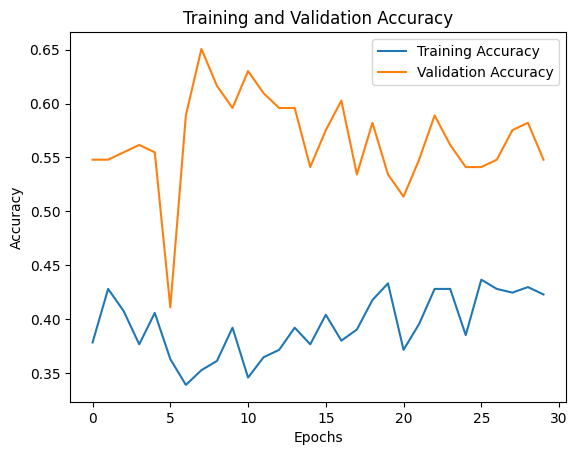

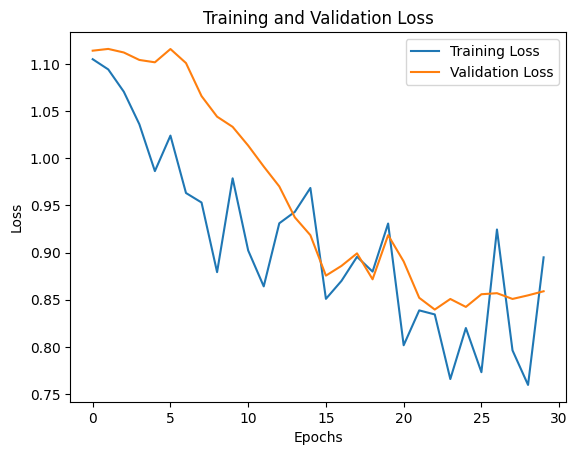

In [404]:
# Plot akurasi selama pelatihan dan validasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss selama pelatihan dan validasi
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Model LSTM telah disimpan.
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4604 - loss: 0.9390   
Training Accuracy: 50.00%
Training Loss: 0.9019
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step

Validation Accuracy: 52.05%

Validation Classification Report:
              precision    recall  f1-score   support

        Aman       0.50      0.88      0.64        52
      Risiko       0.86      0.32      0.47        94
  Tidak Aman       0.00      0.00      0.00         0

    accuracy                           0.52       146
   macro avg       0.45      0.40      0.37       146
weighted avg       0.73      0.52      0.53       146


Validation Confusion Matrix:
[[46  5  1]
 [46 30 18]
 [ 0  0  0]]
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: U

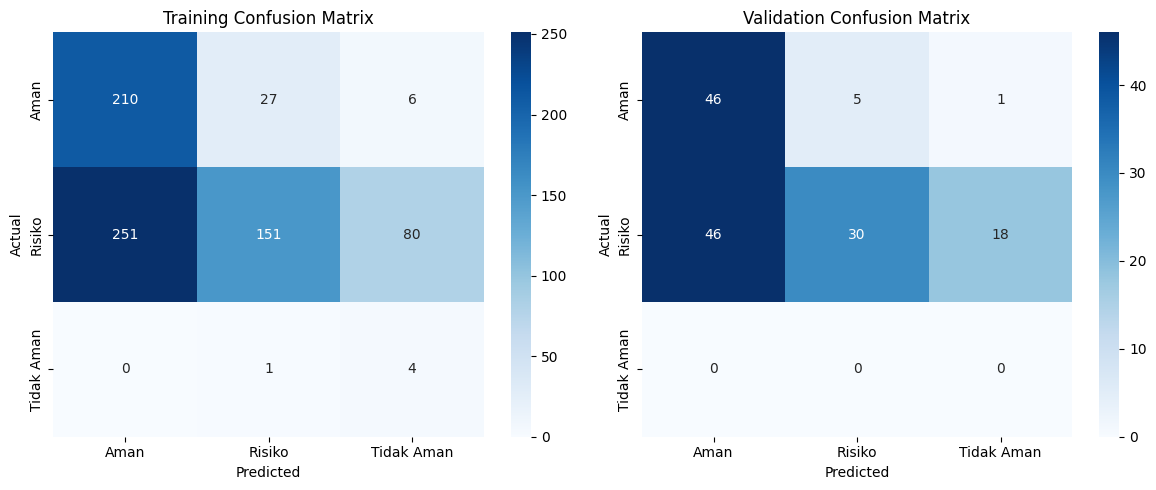

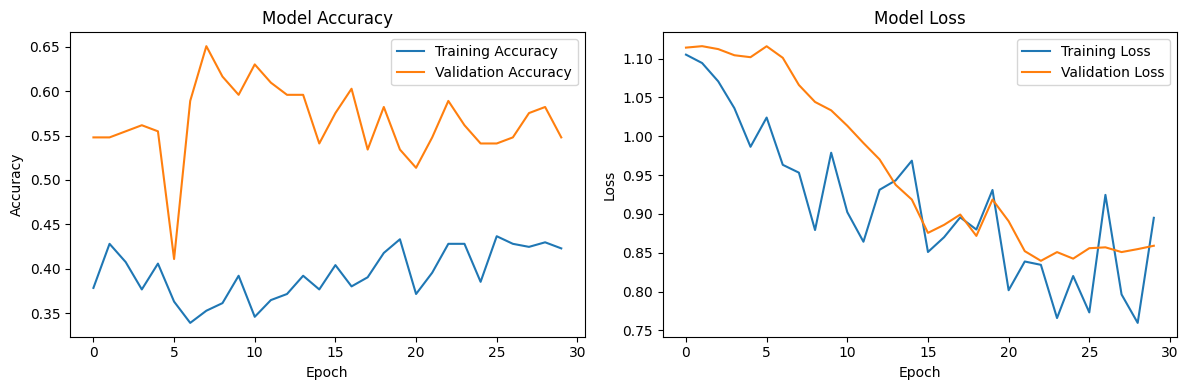


Training Set Class Distribution:
Class 1: 66.44%
Class 0: 32.71%
Class 2: 0.86%

Validation Set Class Distribution:
Class 1: 64.38%
Class 0: 35.62%


In [405]:
# Simpan model
lstm_model.save('lstm_classification_model.h5')
print("Model LSTM telah disimpan.")

# Evaluasi model pada data training
train_loss, train_accuracy = lstm_model.evaluate(X, y)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")


# Split data untuk validasi
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Prediksi pada validation set
y_val_pred = lstm_model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Validasi Accuracy
val_accuracy = accuracy_score(y_val, y_val_pred_classes)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

# Klasifikasi Report untuk Validation Set
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred_classes, 
                            target_names=['Aman', 'Risiko', 'Tidak Aman']))

# Confusion Matrix untuk Validation Set
cm_val = confusion_matrix(y_val, y_val_pred_classes)
print("\nValidation Confusion Matrix:")
print(cm_val)

# Visualisasi Confusion Matrix untuk Validation Set
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))

# Confusion Matrix untuk Training Set
plt.subplot(1,2,1)
cm_train = confusion_matrix(y, np.argmax(lstm_model.predict(X), axis=1))
sns.heatmap(cm_train, annot=True, fmt='d', 
            xticklabels=['Aman', 'Risiko', 'Tidak Aman'],
            yticklabels=['Aman', 'Risiko', 'Tidak Aman'],
            cmap='Blues')
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Confusion Matrix untuk Validation Set
plt.subplot(1,2,2)
sns.heatmap(cm_val, annot=True, fmt='d', 
            xticklabels=['Aman', 'Risiko', 'Tidak Aman'],
            yticklabels=['Aman', 'Risiko', 'Tidak Aman'],
            cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Plot akurasi dan loss
plt.figure(figsize=(12,4))

# Plot Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Analisis distribusi kelas
import pandas as pd

# Distribusi kelas pada training set
train_class_dist = pd.Series(y_train).value_counts(normalize=True)
print("\nTraining Set Class Distribution:")
for label, dist in zip(train_class_dist.index, train_class_dist):
    print(f"Class {label}: {dist*100:.2f}%")

# Distribusi kelas pada validation set
val_class_dist = pd.Series(y_val).value_counts(normalize=True)
print("\nValidation Set Class Distribution:")
for label, dist in zip(val_class_dist.index, val_class_dist):
    print(f"Class {label}: {dist*100:.2f}%")